In [1]:
#импортируем все, что нужно
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers
import numpy as np
import cv2

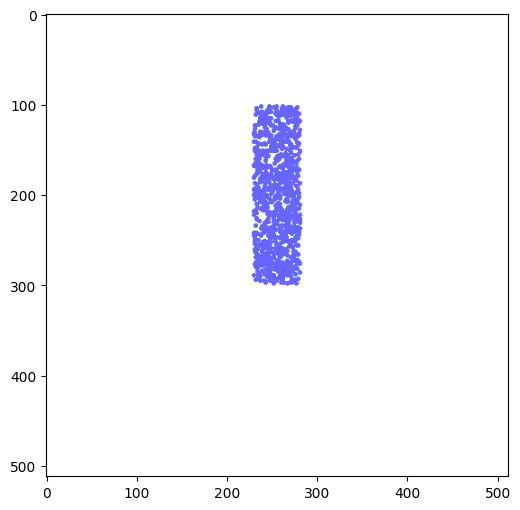

In [2]:
#визуализация
def viz(tensor):
    tensor = tensor.numpy()
    #делим на координаты x и y
    x = tensor[:, 0]/3
    y = tensor[:, 1]/3
    
    #создаем белый экран
    screen = np.ones((512, 512, 3), dtype = np.float32)
    
    for i in range(x.shape[0]):
        #отображаем кружок. координаты приводим от (-1...1) к (0...512) хотя четкого ограничения нет.
        #цвета сдесь (0...1)
        screen = cv2.circle(screen, (int(x[i]*256+ 256), int(y[i]*256 + 256)), 1, (0.4,0.4,1), 2)
    return screen

#генерируем массив исходных 1000 точек, это и будет 'датасетом'
#стакуем координаты по x и по y
tensor = tf.stack([tf.random.uniform([1000], -0.3, 0.3), tf.random.uniform([1000], -1.8, 0.5)], axis = 1)

screen = viz(tensor)
plt.figure(figsize = (10,6))
plt.subplot(1,1,1)
plt.imshow(screen)


plt.show()

In [3]:
#для понимания
min_signal_rate = 0.0
max_signal_rate = 1.0


class DiffusionModel():
    def diffusion_schedule(self, diffusion_times):
        
        #найдем такой угол, для которого cos будет min и max т.е. 0 и 1
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        #переменная diffusion_times сторого от 0 до 1 линейно сдвигает угол от start к end
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        #считаем параметры, основываясь на угол (а по сути на diffusion_times)
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # косинусы с синусами не просто так: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates
    
model = DiffusionModel()

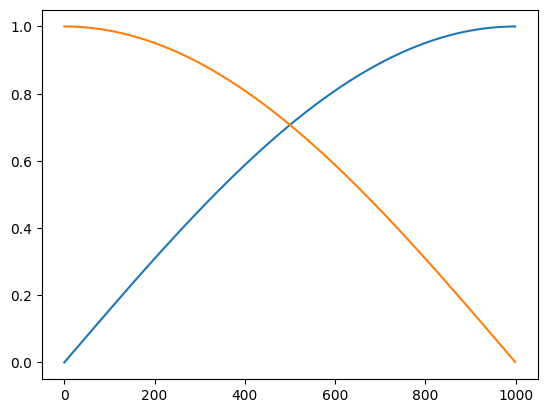

In [4]:
#посмотрим, как параметры меняются в зависимости от времени с начала диффузии
noise_rates = []
signal_rates = []
for tt in range(0, 1000):
    
    t = tt/1000.0
    #и t будет от 0 до 1
    
    noise, signal = model.diffusion_schedule(t)
    noise_rates.append(noise)
    signal_rates.append(signal)
    
#рисуем
plt.plot(np.arange(0,len(noise_rates)), noise_rates)
plt.plot(np.arange(0,len(signal_rates)), signal_rates)
plt.show()

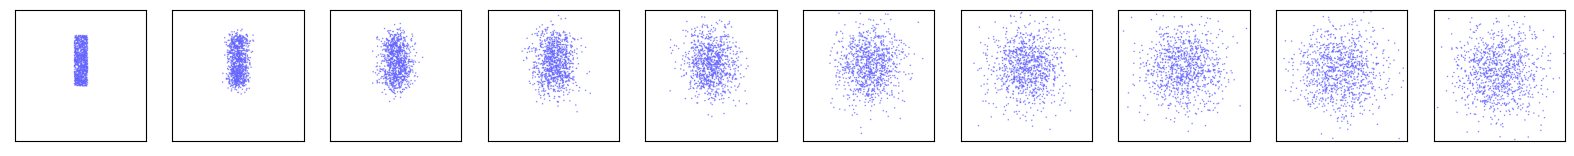

In [5]:
#визуализация процесса диффузии
#каждый раз генерируется новый шум, поэтому точки не просто двигаются (это и не нужно), но их 
#распределение соответствет времени

plt.figure(figsize = (20,20))
for tt in range(0, 10):
    t = tt/10.0
    noise, signal = model.diffusion_schedule(t)
    
    #тут применяем шум
    noised_tensor = noise*tf.random.normal((1000, 2), dtype = tf.float32) + signal * tensor
    
    #рисуем
    plt.subplot(1,10, tt + 1)
    screen = viz(noised_tensor)
    plt.imshow(screen)
    
    #убрали подписи координат
    plt.xticks([])
    plt.yticks([])
plt.show()
    
    